In [1]:
import numpy as np
from source.Files_operating import read_sht_data

shtRipper v1.3


In [2]:
F_ID = 44184
dir_path = "D:/Edu/Lab/Projects/Plasma_analysis/data/sht/G-ELM/"  
# D:/Edu/Lab/Projects/Plasma_analysis/data/sht/G-ELM/ | C:/Users/f.belous/Work/Projects/Plasma_analysis/data/sht/G-ELM/

df = read_sht_data(f'sht{F_ID}', dir_path)
df = df.rename(columns={"ch1": "d_alpha"})
df["sxr"] = read_sht_data(f'sht{F_ID}', dir_path, data_name="SXR 50 mkm").ch1
# dbs = read_dataFile(f'data/dbs/{F_ID} DBS.dat')
# mgd_data_1
# mgd_data_3
# mgd_data_2
df.describe()

,t,d_alpha,sxr
count,393216.000000,393216.000000,393216.000000
mean,0.196608,0.281714,0.386184
std,0.113512,0.393401,0.503047
min,0.000000,-0.388535,-0.076685
25%,0.098304,0.012781,0.107358
50%,0.196607,0.066460,0.109915
75%,0.294911,0.575134,0.439658
max,0.393215,4.818347,2.356772


In [3]:
d_alpha = df.d_alpha.to_numpy()
sxr = df.sxr.to_numpy()

In [4]:
d_alpha_d1 = np.diff(d_alpha)
sxr_d1 = np.diff(sxr)

In [5]:
from scipy import signal

b, a = signal.butter(5, 0.05)
d_alpha_f = signal.filtfilt(b, a, d_alpha_d1)
sxr_f = signal.filtfilt(b, a, sxr_d1)

In [6]:
da_f_q, da_f_std = np.quantile(d_alpha_f, 0.7), d_alpha_f.std()
sxr_f_q, sxr_f_std = np.quantile(sxr_f, 0.8), sxr_f.std()

In [7]:
# indexes_da = np.round(df.t.to_numpy()[:-1][abs(d_alpha_f - da_f_q) > da_f_std * 2] * 1e6)
# indexes_sxr = np.round(df.t.to_numpy()[:-1][abs(sxr_f - sxr_f_q) > sxr_f_std * 6] * 1e6)

# print(da_f_q, da_f_std, indexes_da.shape)
# print(sxr_f_q, sxr_f_std, indexes_sxr.shape)

In [8]:
def get_boarders(data: np.array, loc_max_ind=None, scale=1.5):
    loc_max_ind = np.argmax(data)
    dist_ind = np.argsort(np.abs(data - data[loc_max_ind] / scale))
    return Slice(dist_ind[dist_ind <= loc_max_ind][0], dist_ind[dist_ind >= loc_max_ind][0])


class Slice:
    def __init__(self, start_index=0, end_index=0):
        self.l = start_index
        self.r = end_index
        self.mark = 1.0

    def set_boarders(self, start_index: int, end_index: int) -> None:
        self.l = start_index
        self.r = end_index

    def set_mark(self, mark: int) -> None:
        self.mark = mark

    def copy(self, other):
        self.l = other.l
        self.r = other.r
        self.mark = other.mark

    def check_length(self, len_edge: int) -> bool:
        return self.r - self.l > len_edge

    def check_dist(self, other, dist_edge: int) -> bool:
        return other.l - self.r > dist_edge

    def collide_slices(self, other, dist_edge: int) -> bool:
        if not self.check_dist(other, dist_edge):
            self.r = other.r
            return True
        return False

    def step(self) -> None:
        self.r += 1

    def move(self, delta: int) -> None:
        self.r += delta
        self.l += delta

    def expand(self, delta: int) -> None:
        self.r += delta
        self.l -= delta

    def collapse_boarders(self) -> None:
        self.l = self.r

    def is_null(self) -> bool:
        return self.l == self.r

In [61]:
def proc_slices(mark_data: np.array, data: np.array, data_diff: np.array, meta: Signal_meta) -> np.array:  # data: np.array, , scale=1.5 , step_out=10
    proc_slice = Slice(0, 0)
    cur_slice = Slice(0, 1)
    f_fragment = False

    res_mark = np.copy(mark_data)

    c = 0
    
    while cur_slice.r < res_mark.shape[0]:
        if res_mark[cur_slice.r] == 1.0:
            if not f_fragment:
                f_fragment = True
        elif f_fragment:
            # print(start_ind, end_ind)
            if not cur_slice.check_length(meta.len_edge):
                res_mark[cur_slice.l: cur_slice.r] = 0.0
            elif not proc_slice.collide_slices(cur_slice, meta.dist_edge):
                if meta.proc_fl and meta.scale > 1:
                    res_mark[proc_slice.l: proc_slice.r] = 0.0
                    start_ind = proc_slice.l if data_diff[proc_slice.l] > 0 else proc_slice.r
                    proc_slice = proc_boarders(data, data_diff, start_ind, meta.scale)
                    
                    cur_slice = Slice(proc_slice.r, proc_slice.r)
                
                proc_slice.expand(meta.step_out)

                if meta.proc_fl and abs(data_diff[proc_slice.l:proc_slice.r].max() - meta.q) < meta.std_top * meta.std and \
                   abs(data_diff[proc_slice.l:proc_slice.r].min() - meta.q) < meta.std_top * meta.std:
                    proc_slice.set_mark(0)
                
                res_mark[proc_slice.l: proc_slice.r] = proc_slice.mark
                c += proc_slice.mark
                
                proc_slice.copy(cur_slice)
            f_fragment = False
            cur_slice.collapse_boarders()
        elif not f_fragment:
            cur_slice.collapse_boarders()
            if proc_slice.is_null():
                proc_slice.copy(cur_slice)
    
        cur_slice.step()
    print(c)

    return res_mark

In [17]:
def get_peaks(data: np.array, s_i: int) -> np.array:
    peaks_ind = []
    loc_max = data.min()
    m_v = data.mean()
    loc_max_ind = 0
    increase_fl = False
    for i in range(data.shape[0] - 1):
        if loc_max < data[i]:
            increase_fl = True
            loc_max = data[i]
            loc_max_ind = i
        elif abs((loc_max - data[i]) / (loc_max + 1e-10)) > 0.5 and increase_fl:
            if abs(loc_max) > 5 * abs(m_v + 1e-10):
                peaks_ind.append(loc_max_ind)
            # print(s_i + loc_max_ind, abs((loc_max - data[i]) / loc_max), abs((loc_max - m_v) / m_v))  # len(peaks_ind),
            increase_fl = False

        if not increase_fl or data[i] < data[i + 1]:
            loc_max = data[i]
            loc_max_ind = i
    return np.array(peaks_ind)

def get_boarders_d2(data:np.array, diff_data: np.array, s_i: int, scale=1.5):
    d2_data = np.diff(diff_data)
    peaks_ind = get_peaks(d2_data, s_i)

    if len(peaks_ind) == 0:
        return Slice(0, diff_data.shape[0])
    elif len(peaks_ind) == 1:
        scale_slice = get_boarders(data, scale=scale)
        if peaks_ind[0] < diff_data.shape[0] - peaks_ind[0]:
            if peaks_ind[0] - scale_slice.r > 0:
                return Slice(peaks_ind[0], scale_slice.r)
            else:
                return Slice(peaks_ind[0], diff_data.shape[0])
        elif peaks_ind[0] > diff_data.shape[0] - peaks_ind[0]:
            if peaks_ind[0] - scale_slice.l > 0:
                return Slice(scale_slice.l, peaks_ind[0])
            else:
                return Slice(0, peaks_ind[0])

    return Slice(peaks_ind[0], peaks_ind[-1])

def proc_boarders(data: np.array, data_diff: np.array, start_ind: int, scale=1.5) -> Slice:
    step = 5
    
    diff_coeff = 1
    if data_diff[start_ind] < 0:
        diff_coeff = -1
    
    cur_ind = (start_ind + diff_coeff * step) if 0 < start_ind + diff_coeff * step < data.shape[0] else start_ind
    while 0 < cur_ind + diff_coeff * step < data.shape[0] and data_diff[cur_ind] * data_diff[cur_ind + diff_coeff * step] > 0:
        cur_ind += diff_coeff * step

    # print(cur_ind - 3 * step, cur_ind + 3 * step, end=" ")
    max_ind = np.argmax(data[cur_ind - 3 * step:cur_ind + 3 * step]) + cur_ind - step
    length = max(abs(max_ind - start_ind), 3 * step)
    # print(max_ind, length)

    # print(max_ind - length, max_ind + 2 * length, end=" ")
    res_slice = get_boarders_d2(data[max_ind - length: max_ind + 2 * length], data_diff[max_ind - length: max_ind + 2 * length], max_ind - length, scale=scale)  # get_boarders(data[max_ind - length: max_ind + 2 * length], loc_max_ind=length) | Slice(0, 3 * length)
    res_slice.move(max_ind - length)
    # print(res_slice.l, res_slice.r)

    # add checking diff on right & left boarder (cut on D2 peaks) - done
    # add dtw classification (None | ELM | LSO)

    print(res_slice.l, res_slice.r, end=" ")
    print(abs(data_diff[res_slice.l:res_slice.r].max() - np.quantile(data_diff, 0.7)), data_diff.std())
    
    return res_slice

In [36]:
class Signal_meta:
    def __init__(self, chanel_name="da", processing_flag=False, 
                 quantile_edge=0.0, std_edge=1.0, 
                 length_edge=10, distance_edge=10, scale=1.5, step_out=10, 
                 std_bottom_edge=3, std_top_edge=6):
        self.name = chanel_name
        self.proc_fl = processing_flag
        
        self.len_edge = length_edge
        self.dist_edge = distance_edge
        self.scale = scale
        self.step_out = step_out
        
        self.q = quantile_edge
        self.std = std_edge

        self.std_top = 3
        self.std_bottom = 6
        
    def set_statistics(self, data: np.array, percentile: float, std_bottom_edge=3, std_top_edge=6):
        self.q = np.quantile(data, percentile)
        self.std = data.std()
        self.std_top = std_top_edge
        self.std_bottom = std_bottom_edge

    def set_edges(self, length_edge=10, distance_edge=10, scale=1.5, step_out=10):
        self.len_edge = length_edge
        self.dist_edge = distance_edge
        self.scale = scale
        self.step_out = step_out

In [66]:
meta_da = Signal_meta(chanel_name="da", processing_flag=True)
meta_da.set_statistics(d_alpha_f, 0.7, std_bottom_edge=1.5, std_top_edge=2.7)
meta_da.set_edges(length_edge=15, distance_edge=30)

meta_da_2 = Signal_meta(chanel_name="da", processing_flag=False)
meta_da_2.set_statistics(d_alpha_f, 0.7, std_bottom_edge=1.5, std_top_edge=2.5)
meta_da_2.set_edges(length_edge=15, distance_edge=30)

meta_sxr = Signal_meta(chanel_name="sxr", processing_flag=True)
meta_sxr.set_statistics(sxr_f, 0.8, std_bottom_edge=7.0, std_top_edge=15.0)
meta_sxr.set_edges(length_edge=10, distance_edge=30, scale=0)

In [67]:
mark_data = np.zeros(d_alpha_f.shape)
mark_data[abs(d_alpha_f - meta_da.q) > meta_da.std * meta_da.std_bottom] = 1
mark_d_alpha = proc_slices(mark_data, d_alpha, d_alpha_f, meta_da)

mark_data = np.zeros(d_alpha_f.shape)
mark_data[abs(d_alpha_f - meta_da_2.q) > meta_da_2.std * meta_da_2.std_bottom] = 1
mark_d_alpha_2 = proc_slices(mark_data, d_alpha, d_alpha_f, meta_da_2)

mark_data = np.zeros(d_alpha_f.shape)
mark_data[abs(sxr_f - meta_sxr.q) > meta_sxr.std * meta_sxr.std_bottom] = 1
mark_sxr = proc_slices(mark_data, sxr, sxr_f, meta_sxr)

110519 110568 0.010339585782443187 0.002314248030679259
120913 120960 0.004934194450279438 0.002314248030679259
121307 121331 0.0009152966771415408 0.002314248030679259
123154 123208 0.0023241939876987644 0.002314248030679259
123339 123456 0.005756767227969276 0.002314248030679259
125297 125363 0.004449504066492846 0.002314248030679259
125404 125494 0.0016638489001887516 0.002314248030679259
129614 129676 0.004618202806629487 0.002314248030679259
131042 131093 2.6905809861953948e-05 0.002314248030679259
131882 132002 0.00417330248891225 0.002314248030679259
133841 133889 0.0034299344865260243 0.002314248030679259
134573 134675 0.004222231365804198 0.002314248030679259
135172 135268 0.004926877846407397 0.002314248030679259
135638 135688 0.004790437125836786 0.002314248030679259
135921 136011 0.004984017798398917 0.002314248030679259
136154 136278 0.004674023818400841 0.002314248030679259
136280 136331 0.0038599014437865607 0.002314248030679259
136519 136579 0.00019206814556407977 0.002

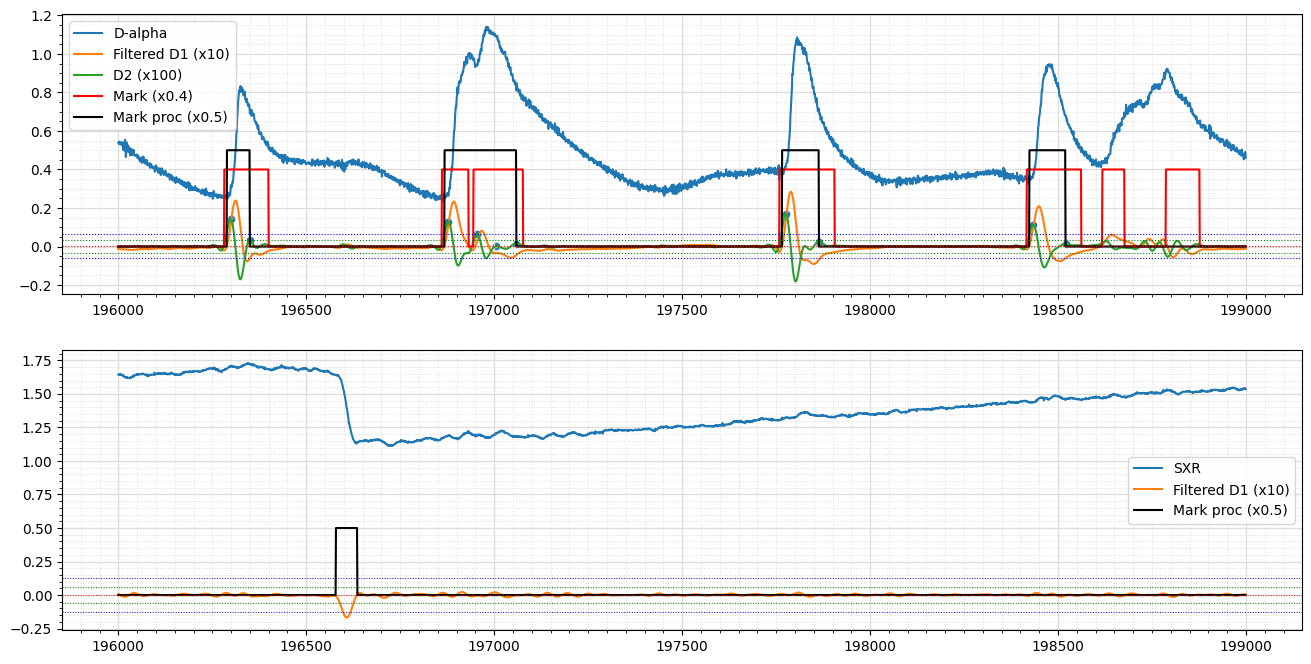

ELM fragment (0.19599999999999998 - 0.19899999999999998 ms)



In [70]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

def get_d2_peaks(diff_data: np.array, mark_data: np.array, s_i: int) -> np.array:
    l_ = 0
    fr_fl = False
    peaks_ind = []
    for i in range(mark_data.shape[0]):
        if mark_data[i] == 1 and not fr_fl:
            fr_fl = True
            l_ = i
        elif fr_fl and mark_data[i] == 0:
            fr_fl = False
            d2_data = np.diff(diff_data)
            res = get_peaks(d2_data[l_-10:i+30], s_i) + l_-10
            peaks_ind += res.tolist()
    peaks_ind = np.array(peaks_ind)
    return peaks_ind, d2_data[peaks_ind]

mode_plotting = 1  # int(input("Input visualising mode [ 0 - manual | 1 - only marked ]:"))
# mode_marking = int(input("Input marking mode (0 - manual | 1 - semiauto): ").strip().split()[0])
l_edge = 196000  # int(input(f"Input start index [0:{df.shape[0]//1000*1000}]: ").strip().split()[0])
# print("---")
step = 2000
width = 3000

step_away = 10

while l_edge < df.shape[0]:
    r_edge = min(l_edge + width, df.shape[0] - 1)
    
    if mode_plotting == 1 and sum(mark_d_alpha[l_edge:r_edge]) == 0 and sum(mark_sxr[l_edge:r_edge]) == 0:
        l_edge += step
        continue
    
    fig, [ax1, ax2] = plt.subplots(2, 1)

    fig.set_figwidth(16)
    fig.set_figheight(8)

    ax1.plot(range(l_edge, r_edge), d_alpha[l_edge:r_edge], label="D-alpha")
    # ax1.plot(range(l_edge, r_edge), d_alpha_d1[l_edge:r_edge], label="Diff 1")
    ax1.plot(range(l_edge, r_edge), d_alpha_f[l_edge:r_edge] * 10, label="Filtered D1 (x10)")
    ax1.plot(range(l_edge, r_edge), np.diff(d_alpha_f)[l_edge:r_edge] * 100, label="D2 (x100)")

    x, y = get_d2_peaks(d_alpha_f[l_edge:r_edge], mark_d_alpha[l_edge:r_edge], l_edge)
    x = x + l_edge
    # print(len(x), x, y)
    ax1.scatter(x, y * 100, s=20)

    ax1.plot(range(l_edge, r_edge), mark_d_alpha_2[l_edge:r_edge] * 0.4, label="Mark (x0.4)", color="red")
    ax1.plot(range(l_edge, r_edge), mark_d_alpha[l_edge:r_edge] * 0.5, label="Mark proc (x0.5)", color="black")
    ax1.axhline(np.quantile(d_alpha_f, 0.7) * 10, color="red", linestyle=':', linewidth=0.8)
    ax1.axhline((meta_da.q + meta_da.std * meta_da.std_bottom) * 10, color="green", linestyle=':', linewidth=0.8)
    ax1.axhline((meta_da.q - meta_da.std * meta_da.std_bottom) * 10, color="green", linestyle=':', linewidth=0.8)
    ax1.axhline((meta_da.q + meta_da.std * meta_da.std_top) * 10, color="blue", linestyle=':', linewidth=0.8)
    ax1.axhline((meta_da.q - meta_da.std * meta_da.std_top) * 10, color="blue", linestyle=':', linewidth=0.8)

    ax1.grid(which='major', color='#DDDDDD', linewidth=0.9)
    ax1.grid(which='minor', color='#DDDDDD', linestyle=':', linewidth=0.7)
    ax1.minorticks_on()
    ax1.xaxis.set_minor_locator(AutoMinorLocator(10))
    ax1.legend()

    ax2.plot(range(l_edge, r_edge), sxr[l_edge:r_edge], label="SXR")
    # ax2.plot(range(l_edge, r_edge), sxr_d1[l_edge:r_edge], label="Diff 1")
    ax2.plot(range(l_edge, r_edge), sxr_f[l_edge:r_edge] * 10, label="Filtered D1 (x10)")
    ax2.plot(range(l_edge, r_edge), mark_sxr[l_edge:r_edge] * 0.5, label="Mark proc (x0.5)", color="black")
    ax2.axhline(np.quantile(sxr_f, 0.8) * 10, color="red", linestyle=':', linewidth=0.7)
    ax2.axhline((meta_sxr.q + meta_sxr.std * meta_sxr.std_bottom) * 10, color="green", linestyle=':', linewidth=0.7)
    ax2.axhline((meta_sxr.q - meta_sxr.std * meta_sxr.std_bottom) * 10, color="green", linestyle=':', linewidth=0.7)
    ax2.axhline((meta_sxr.q + meta_sxr.std * meta_sxr.std_top) * 10, color="blue", linestyle=':', linewidth=0.7)
    ax2.axhline((meta_sxr.q - meta_sxr.std * meta_sxr.std_top) * 10, color="blue", linestyle=':', linewidth=0.7)

    ax2.grid(which='major', color='#DDDDDD', linewidth=0.9)
    ax2.grid(which='minor', color='#DDDDDD', linestyle=':', linewidth=0.7)
    ax2.minorticks_on()
    ax2.xaxis.set_minor_locator(AutoMinorLocator(10))
    ax2.legend()
    plt.show()

    # res = list(map(int, input(f"Input index pairs of ELM fragments ({df.t[l_edge]} - {df.t[r_edge]} ms):\n").strip().split()))
    # for i in range(0, len(res), 2):
    #     board_ind = [res[i], res[i+1]]

    #     mark = float(input("Input mark to set [ 0 | 1 | 2 ]: "))
        
    #     if mode_marking and mark > 0:
    #         board_ind = get_borders(df.loc[res[i]:res[i + 1], "ch1"].to_numpy(), scale=1.5)
    #         board_ind[0] = max(board_ind[0] - step_away + res[i], 0)
    #         board_ind[1] += res[i]
        
    #     df.loc[board_ind[0]:board_ind[1], "ch1_marked"] = mark

    print(f"ELM fragment ({df.t[l_edge]} - {df.t[r_edge]} ms)\n")
    break
    # input(f"ELM fragment ({df.t[l_edge]} - {df.t[r_edge]} ms)\n")

    plt.close()
    plt.clf()
    l_edge += step

# 217500

In [115]:
def process_fragments(data: np.array, mark_data: np.array, length_edge=10, distance_edge=25, scale=1.5, step_out=10) -> np.array:
    proc_slice = Slice(0, 0)
    cur_slice = Slice(0, 1)
    f_fragment = False

    while cur_slice.r < mark_data.shape[0]:
        if mark_data[cur_slice.r] == 1.0:
            if not f_fragment:
                f_fragment = True
        elif f_fragment:
            # print(start_ind, end_ind)
            if scale <= 1:
                if not cur_slice.check_length(length_edge):
                    mark_data[cur_slice.l: cur_slice.r] = 0.0
                elif not proc_slice.collide_slices(cur_slice, distance_edge):
                    mark_data[proc_slice.l: proc_slice.r] = 1.0
                    proc_slice.copy(cur_slice)
            elif scale:
                mark_data[cur_slice.l: cur_slice.r] = 0.0
                if cur_slice.check_length(length_edge):
                    boarders = get_boarders(data[cur_slice.l: cur_slice.r], scale)
                    # print(boards)
                    boarders[0] = max(boarders[0] + cur_slice.l - step_out, 0)
                    boarders[1] = min(boarders[1] + cur_slice.l, mark_data.shape[0])

                    mark_data[boarders[0]:boarders[1]] = 1.0

            f_fragment = False
            cur_slice.collapse_borders()
        elif not f_fragment:
            cur_slice.collapse_borders()
            if proc_slice.is_null():
                proc_slice.copy(cur_slice)

        cur_slice.step()

    return mark_data